In [4]:
%load_ext autoreload
%autoreload 2
from PIL import Image as im
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from skimage.transform import resize
from skimage.feature import local_binary_pattern as lbp
from skimage.filters.rank import gradient_percentile
from skimage.filters import sobel
from scipy.ndimage import convolve, correlate
from skimage.transform import resize, finite_radon_transform
from skimage import exposure
from skimage.draw import circle, polygon


In [5]:
def _reshape_segm_data(segm_list, src_h, dst_h):
    resize_ratio = float(dst_h) / src_h
    return list(map(lambda x: int(resize_ratio * x), segm_list))

def _get_segm_dict(markup_file_path):
    segm_data = dict()
    with open(markup_file_path, 'r') as f:
        lines = f.readlines()[1:]
        for row in lines:
            data = row.split('\t')
            name = data[0]
            xp,yp,rp = map(int, data[4:7])
            xi,yi,ri = map(int, data[8:11])
            segm_data[name] = [xp, yp, rp, xi, yi, ri]
    return segm_data

DATA_DIR = r'D:\code\rep\IrisData'
file_list = list()
image_list = list()
data_list = list()
with open(os.path.join(DATA_DIR, 'params_res.txt'), 'r') as f:
    lines = f.readlines()
    for ln in lines[1:10]:
        raw_ = ln.strip('\n').split('\t')
        seg = raw_[12:15]+raw_[16:19]
        file_list.append(raw_[0])
        image_list.append(np.array(im.open(os.path.join(DATA_DIR, raw_[0]))))
        data_list.append(list(map(int, seg)))

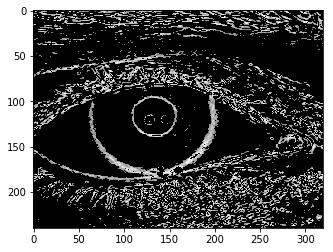

In [31]:

def GetEdgeMap(src, segm_data):
    h, w = src.shape
    xP, yP, rP, xI, yI, rI = segm_data
    sobelDx = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
    sobelDy = sobelDx.T
    
    xCoords = np.repeat(np.arange(w).reshape(1,-1), h, axis=0) - xI * np.ones((h,w))
    yCoords = np.repeat(np.arange(h).reshape(-1,1), w, axis=1) - yI * np.ones((h,w))
    
    srcDx = np.array(correlate(src, sobelDx, mode='reflect')).astype(np.int)
    srcDy = np.array(correlate(src, sobelDy, mode='reflect')).astype(np.int)
    srcAngleMap = np.arctan2(srcDy, srcDx)
    srcMagnitude = np.sqrt(srcDx*srcDx + srcDy*srcDy)
    srcMagnitudeThresholdHigh = np.percentile(srcMagnitude.ravel(), 95)
    srcMagnitudeThresholdLow = np.percentile(srcMagnitude.ravel(), 75)
    srcMagnitude = srcMagnitude * (srcMagnitude < srcMagnitudeThresholdHigh)
    srcMagnitude = srcMagnitude * (srcMagnitude > srcMagnitudeThresholdLow)
    
    # cos(20) ~ 0.95, 1/cos(20) ~ 1.05
    srcMagnitude = srcMagnitude * (1.05 * (srcDx*xCoords + srcDy*yCoords) ** 2 > (xCoords**2 + yCoords**2) * srcMagnitude)
    plt.imshow(srcMagnitude, cmap='gray')
    plt.show()
    return srcMagnitude, srcAngleMap
    # return dts

dst_size = (240,320)
i = 0
img = image_list[i]
src = (resize(img, dst_size, mode='reflect') * 255).astype(np.int)
segm_data = _reshape_segm_data(data_list[i], img.shape[0], src.shape[0])
srcMag, srcAngleMap = GetEdgeMap(src, segm_data)
# Xi, yi = GetFeaturesFromImage(src, segm_data, 100, 150)

Wall time: 6.12 s


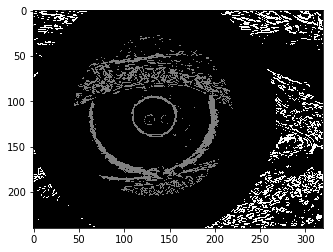

In [35]:
%%time
from sklearn import mixture
def GetFeatures(src, srcAngles, segm_data):
    xP,yP,rP, xI, yI, rI = segm_data
    h,w = src.shape
    features = list()
    fvSize = 0
    
    for y in range(h):
        for x in range(w):
            if src[y,x] > 0:
                fv = [(x-xI)**2 + (y-yI)**2, srcAngles[y,x]]
                # fv = [x**2 + y**2, x, y, 1, ]
                fvSize = len(fv)
                features.append(fv)
    assert fvSize > 0
    return np.array(features).reshape(-1, len(fv))

def predictEdgeMap(srcEdge, srcAngles, model, segm_data):
    xP,yP,rP, xI, yI, rI = segm_data
    h,w = srcEdge.shape
    features = list()
    dst = np.copy(srcEdge)
    for y in range(h):
        for x in range(w):
            if srcEdge[y,x] > 0:
                fv = [(x-xI)**2 + (y-yI)**2, srcAngles[y,x]]
                # fv = [x**2 + y**2, x, y, 1]
                dst[y,x] = 32 * model.predict(np.array(fv).reshape(1,-1))
    plt.imshow(dst, cmap='gray')
    return dst

fvs = GetFeatures(srcMag, srcAngleMap, segm_data)
# gmm = mixture.GaussianMixture(n_components=3, covariance_type='spherical').fit(fvs)

dpgmm = mixture.BayesianGaussianMixture(n_components=3, covariance_type='spherical').fit(fvs)

# y_pred = dpgmm.predict(fvs)
predictEdgeMap(srcMag, srcAngleMap, dpgmm, segm_data)

# print(dpgmm.weights_)
# print(dpgmm.means_)
# print(segm_data)

# plt.subplot(121)
# plt.imshow(srcMag, cmap='gray')
# x,y,r = dpgmm.means_[0]
# cGMM = plt.Circle((x, y), r, color='cyan', fill=False)
# plt.gcf().gca().add_artist(cGMM)
# plt.axis('off')
# plt.subplot(122)
# plt.imshow(srcMag, cmap='gray')
# x,y,r = dpgmm.means_[1]
# cGMM2 = plt.Circle((x, y), r, color='cyan', fill=False)
# plt.gcf().gca().add_artist(cGMM2)
# plt.axis('off')
# fig = plt.gcf()
# fig.set_size_inches(9, 5)

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=10).fit_transform(fvs)

In [ ]:
y_pred = dpgmm.predict(fvs)
X_embedded_0 = X_embedded[y_pred == 0]
X_embedded_1 = X_embedded[y_pred == 1]
X_embedded_2 = X_embedded[y_pred == 2]
plt.scatter(X_embedded_0[:, 0], X_embedded_0[:, 1], c="r")
plt.scatter(X_embedded_1[:, 0], X_embedded_1[:, 1], c="g")
plt.scatter(X_embedded_2[:, 0], X_embedded_2[:, 1], c="b")
plt.show()

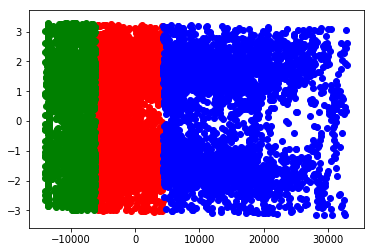

In [36]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(fvs)
y_pred = dpgmm.predict(fvs)
X_pca_0 = X_pca[y_pred == 0]
X_pca_1 = X_pca[y_pred == 1]
X_pca_2 = X_pca[y_pred == 2]
plt.scatter(X_pca_0[:, 0], X_pca_0[:, 1], c="r")
plt.scatter(X_pca_1[:, 0], X_pca_1[:, 1], c="g")
plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c="b")
plt.show()

In [133]:
def GetFeaturesFromImage(src, segm_data, upperEyelid, lowerEyelid):
    h,w = src.shape
    xP, yP, rP, xI, yI, rI = segm_data
    srcLBP = lbp(src, 8, 2)
    
    ## Sobel processing
    sobelDx = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
    sobelDy = sobelDx.T
    
    srcDx = np.array(correlate(src, sobelDx, mode='reflect')).astype(np.int)
    srcDy = np.array(correlate(src, sobelDy, mode='reflect')).astype(np.int)
    srcMagnitude = np.sqrt(srcDx*srcDx + srcDy*srcDy)
    
    srcMagnitudeThresholdHigh = np.percentile(srcMagnitude.ravel(), 95)
    
    # src_val_thresh_low = np.percentile(src_val.ravel(), 50)

    srcMagnitude = srcMagnitude * (srcMagnitude < srcMagnitudeThresholdHigh)
    # srcMagnitude = np.array(srcMagnitude.astype(float) / srcMagnitudeThresholdHigh * 255).astype(np.uint8)
    # print(max(srcDx.ravel()), max(srcDy.ravel()), max(srcMagnitude.ravel()), type(srcMagnitude))
    # srcTangentMap = srcDy / srcDx
    srcAngleMap = np.arctan2(srcDy, srcDx)
    # print(min(srcAngleMap.ravel()))
    rrPo, ccPo = circle(xP, yP, rP+3)
    rrPi, ccPi = circle(xP, yP, rP-3)
    rrIo, ccIo = circle(yI, xI, rI+3)
    rrIi, ccIi = circle(yI, xI, rI-3)
    irisEdgeMap = np.zeros(src.shape)
    # irisEdgeMap[rrP, ccP] = 1
    irisEdgeMap[rrIo, ccIo] = 1
    
    irisTmpIn = np.zeros(src.shape)
    irisTmpIn[rrIi, ccIi] = 1
    irisEdgeMap -= irisTmpIn
    '''
    irisTmpIn[rrPo, ccPo] = 1
    irisEdgeMap += irisTmpIn
    irisTmpIn = np.zeros(src.shape)
    irisTmpIn[rrPi, ccPi] = 1
    irisEdgeMap -= irisTmpIn
    '''
    GoodFeatureList = []
    BadFeatureList = []
    if lowerEyelid > 0 and upperEyelid > 0:
        irisTmpIn = np.zeros(src.shape)
        c = [0, 0, w, w, 0]
        r = [upperEyelid, lowerEyelid, lowerEyelid, upperEyelid, upperEyelid]
        rr, cc = polygon(r, c)
        irisTmpIn[rr, cc] = 1
        irisEdgeMap *= irisTmpIn
        FeatureNumber = np.sum(irisEdgeMap.ravel())
        print(FeatureNumber)
        for y in range(h):
            for x in range(w):
                if y < upperEyelid or y > lowerEyelid:
                    BadFeatureList.append([srcMagnitude[y,x],
                                        srcAngleMap[y,x],
                                        srcLBP[y,x]])
                if irisEdgeMap[y,x] == 1:
                    GoodFeatureList.append([srcMagnitude[y,x],
                                        srcAngleMap[y,x],
                                        srcLBP[y,x]])
        X = np.array(GoodFeatureList + BadFeatureList[::20])
        y = np.hstack([np.ones(len(GoodFeatureList)), np.zeros(len(BadFeatureList[::20]))])
    
    plt.subplot(121)
    plt.imshow(srcMagnitude, cmap='gray')
    cP = plt.Circle((xP, yP), rP, color='cyan', fill=False)
    cI = plt.Circle((xI, yI), rI, color='cyan', fill=False)
    plt.gcf().gca().add_artist(cP)
    plt.gcf().gca().add_artist(cI)
    # plt.axis('off')
    # plt.savefig(r'D:\code\IrisRepository\research\BaseRadii\src.png', bbox_inches='tight')
    plt.subplot(122)
    plt.imshow(irisEdgeMap, cmap='gray', alpha=0.7)
    plt.imshow(src, cmap='gray', alpha = 0.7)
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    
    if upperEyelid != 0 and lowerEyelid != 0:
        return X,y 

632.0


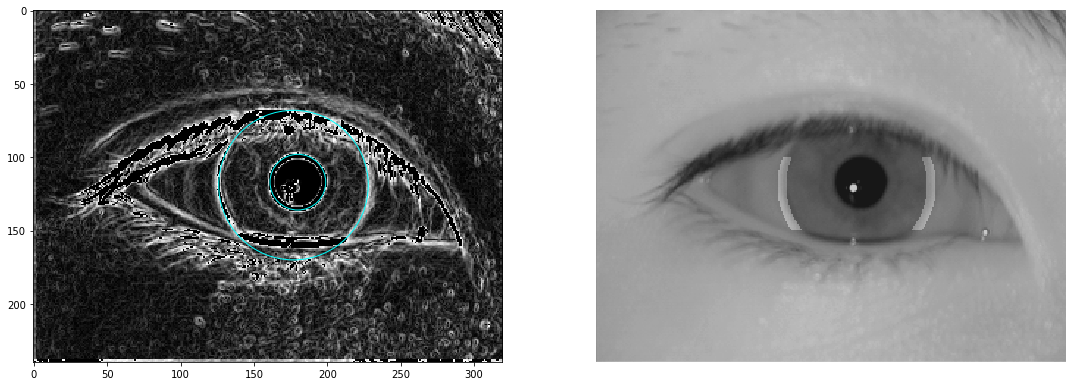

In [146]:
dst_size = (240,320)
i = 9
img = image_list[i]
src = (resize(img, dst_size, mode='reflect') * 255).astype(np.int)
# print(type(src), src.shape, max(src.ravel()))
segm_data = _reshape_segm_data(data_list[i], img.shape[0], src.shape[0])
# GetFeaturesFromImage(src, segm_data, 0, 0)
Xi, yi = GetFeaturesFromImage(src, segm_data, 100, 150)
X = np.vstack([X,Xi])
y = np.hstack([y,yi])

In [149]:
nFeatures = len(X)
nFeatures//

150150

In [150]:
X_train, X_test = X[:nFeatures//2], X[nFeatures//2:]
y_train, y_test = y[:nFeatures//2], y[nFeatures//2:]

In [159]:
from sklearn.linear_model import LogisticRegression
c = 1e-4
LogModel = LogisticRegression(random_state=42, C=c, penalty='l2')
LogModel.fit(X_train, y_train)
print(LogModel.score(X_train, y_train), LogModel.score(X_test, y_test))

0.975291375291 0.901511821512


In [160]:
LogModel.coef_[0]

array([-0.01867032,  0.13347379, -0.01224321])

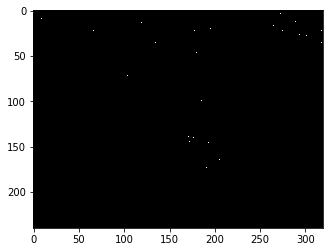

In [166]:
dst_size = (240,320)
i = 3
img = image_list[i]
src = (resize(img, dst_size, mode='reflect') * 255).astype(np.int)
# print(type(src), src.shape, max(src.ravel()))
segm_data = _reshape_segm_data(data_list[i], img.shape[0], src.shape[0])
h,w = src.shape
xP, yP, rP, xI, yI, rI = segm_data
srcLBP = lbp(src, 8, 2)

## Sobel processing
sobelDx = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])
sobelDy = sobelDx.T
srcDx = np.array(correlate(src, sobelDx, mode='reflect')).astype(np.int)
srcDy = np.array(correlate(src, sobelDy, mode='reflect')).astype(np.int)
srcMagnitude = np.sqrt(srcDx*srcDx + srcDy*srcDy)
srcMagnitudeThresholdHigh = np.percentile(srcMagnitude.ravel(), 95)
srcMagnitude = srcMagnitude * (srcMagnitude < srcMagnitudeThresholdHigh)
srcAngleMap = np.arctan2(srcDy, srcDx)
res = list(map(lambda x: LogModel.predict(np.array(x).reshape(1,-1)), zip(srcMagnitude.ravel(),
                                                        srcAngleMap.ravel(),
                                                       srcLBP.ravel())))
plt.imshow(np.array(res).reshape(h,w), cmap='gray')

In [108]:
dst = sobel(src)
dst = dst.ravel()
maxdst = max(dst)
dst[dst > 0.2 * maxdst] = 0
dst = dst.reshape(src.shape)

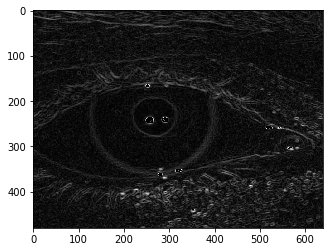

In [25]:
plt.imshow(dst, cmap='gray')

In [9]:
file_list[0]

'0000(I-1-1)060614-131746_e_0_116.bmp\t266\t230\t26030\t267\t230\t46\t85\t261\t230\t127\t85\t267\t233\t44\t32\t264\t233\t136\t97\t0\t0\t0\t0'

In [ ]:
        
image_list = [np.array(im.open(os.path.join(SRC_ER_DIR, filename))) for filename in live_file_list]